# CNN Cancer Detection Kaggle Mini-Project

## Setup

In [1]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.30G/6.31G [00:49<00:00, 190MB/s]
100% 6.31G/6.31G [00:49<00:00, 138MB/s]


In [3]:
!unzip histopathologic-cancer-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d5e86165f63c57acdf9d23521f2b8070e0c.tif  
  inflating: train/fa2ffa

## **Brief Description of the Problem**  
The Histopathologic Cancer Detection challenge aims to classify small histopathology image patches based on whether they contain metastatic tumor tissue. Each image patch is labeled as “1” if tumor tissue is present in the central region (32×32 pixels) and “0” otherwise. This is a binary classification problem where the goal is to build a predictive model that accurately identifies cancerous regions.

**Data Overview**  
- **Dataset Origin**: Adapted from the PatchCamelyon (PCam) benchmark dataset, but duplicate images have been removed for this competition.  
- **Data Volume**: Approximately 277,000 images, totaling about 7.76 GB of data.  
- **Image Dimensions**: Each pathology image is a small patch (96×96 pixels in color TIF format), with only the center 32×32 pixels determining the positive or negative label.  
- **Structure**:
  - **train folder**: Contains training images with corresponding ground-truth labels in `train_labels.csv`.
  - **test folder**: Contains unlabeled images for which predictions must be made.
  - **sample_submission.csv**: Illustrates the required format for final predictions.
- **Labels**:
  - **1**: Tumor tissue present in the center region.
  - **0**: No tumor tissue in the center region.

Although the primary focus is on image data, the structured labels (CSV files) may enable exploration of NLP-like techniques for metadata handling or data augmentation, but the core problem is image-based classification.

===== Dataset Info =====
Number of training labels: 220025
Label column name(s): ['id', 'label']

Label Distribution:
label
0    130908
1     89117
Name: count, dtype: int64

Sample image ID: f38a6374c348f90b587e046aac6079959adf3835
Sample image size (width x height): (96, 96)


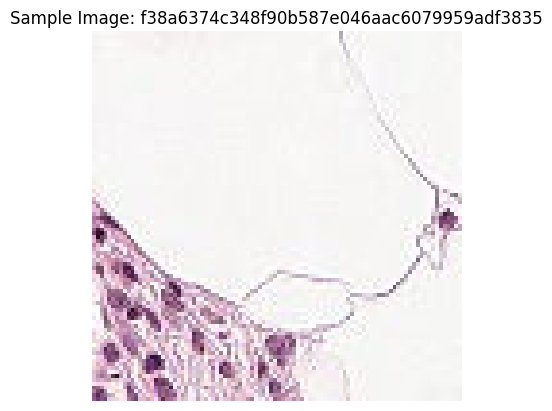

In [4]:
# ---------------------------------------------------------
# STEP 1: Brief Description + Basic Data Exploration
# ---------------------------------------------------------
# The Histopathologic Cancer Detection challenge is a binary
# classification task to determine whether a 96×96 pathology
# image patch has tumor tissue in its 32×32 center region.

import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# 1. LOAD TRAINING LABELS
train_labels = pd.read_csv("train_labels.csv")

# 2. DESCRIBE THE DATA
print("===== Dataset Info =====")
print(f"Number of training labels: {train_labels.shape[0]}")
print(f"Label column name(s): {list(train_labels.columns)}")

# Check label distribution (0 = no tumor, 1 = tumor)
label_counts = train_labels['label'].value_counts()
print("\nLabel Distribution:")
print(label_counts)

# 3. SHOW A SAMPLE IMAGE
#   - We'll pick the first image from train_labels.csv as an example
sample_id = train_labels.loc[0, 'id']
sample_path = os.path.join("train", sample_id + ".tif")

# Ensure the file exists
if os.path.exists(sample_path):
    sample_img = Image.open(sample_path)
    print(f"\nSample image ID: {sample_id}")
    print(f"Sample image size (width x height): {sample_img.size}")
    plt.imshow(sample_img)
    plt.title(f"Sample Image: {sample_id}")
    plt.axis('off')
    plt.show()
else:
    print("\nSample image file not found. Please verify the data path.")

# 4. BASIC CONCLUSION
# - We have ~277k images split into 'train' and 'test' directories.
# - Each image is 96×96 pixels (RGB). The center 32×32 pixels determine the label.
# - train_labels.csv links each image ID to a binary label (0 or 1).
# - This sets up a straightforward classification task.

## Exploratory Data Analysis (EDA)

1. **Inspect the Data**: Check label distribution, missing values, duplicates, and any anomalies.  
2. **Visualize the Data**: Generate histograms or other plots to understand label imbalance. Display sample images, color histograms, etc.  
3. **Clean the Data (if necessary)**: Identify and remove corrupted files, handle missing/duplicate labels (if any).  
4. **Plan of Analysis**: Summarize insights from the EDA and outline a preliminary plan for modeling.

### 1. Inspect the Data

#### 1.1 Load Libraries and Data

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# For inline plots in Jupyter
%matplotlib inline

# Load train labels
train_labels = pd.read_csv("train_labels.csv")

# Print basic info
print(f"Total training images (rows in train_labels.csv): {len(train_labels)}")
print("Columns:", train_labels.columns.tolist())

# Display the first few rows
train_labels.head()

Total training images (rows in train_labels.csv): 220025
Columns: ['id', 'label']


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


#### 1.2 Check for Missing or Duplicate Values


In [6]:
# Check for any missing values
missing_values = train_labels.isnull().sum()
print("\nMissing Values:\n", missing_values)

# Check for duplicate IDs
duplicates = train_labels.duplicated(subset=['id']).sum()
print("\nDuplicate IDs in train_labels.csv:", duplicates)


Missing Values:
 id       0
label    0
dtype: int64

Duplicate IDs in train_labels.csv: 0


#### 1.3 Label Distribution


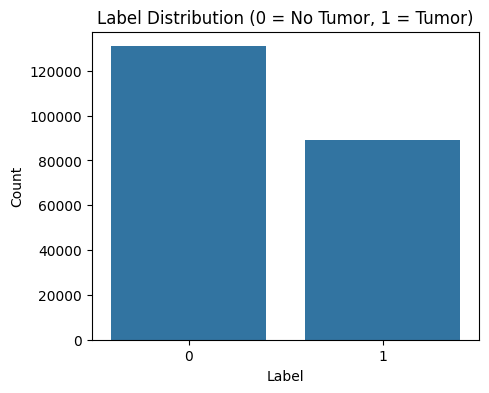


Label Distribution:
 label
0    130908
1     89117
Name: count, dtype: int64


In [7]:
label_counts = train_labels['label'].value_counts()
plt.figure(figsize=(5, 4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Label Distribution (0 = No Tumor, 1 = Tumor)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

print("\nLabel Distribution:\n", label_counts)

### 2. Visualize the Data

#### 2.1 Look at Sample Images

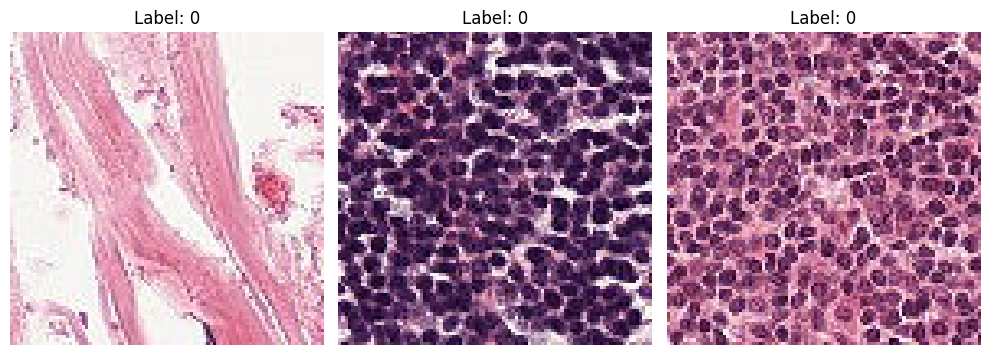

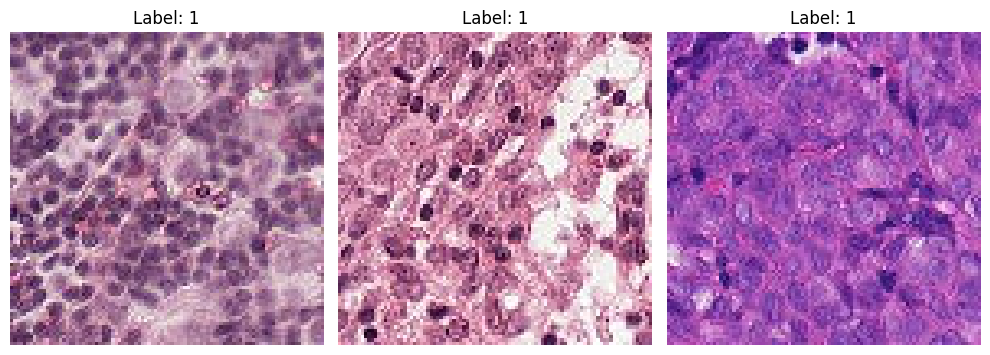

In [8]:
import random

def display_random_images(dataframe, label, n=3):
    """
    Display n random images from the given label (0 or 1).
    """
    # Filter the dataframe to the specified label
    df_label = dataframe[dataframe['label'] == label]

    # Randomly select n IDs
    random_ids = df_label['id'].sample(n, random_state=42).values

    plt.figure(figsize=(10, 4))
    for i, img_id in enumerate(random_ids):
        img_path = os.path.join("train", img_id + ".tif")
        if os.path.exists(img_path):
            img = Image.open(img_path)
            plt.subplot(1, n, i+1)
            plt.imshow(img)
            plt.title(f"Label: {label}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display a few images for each label
display_random_images(train_labels, label=0, n=3)
display_random_images(train_labels, label=1, n=3)

#### 2.2 Optional: Color Channel Histograms


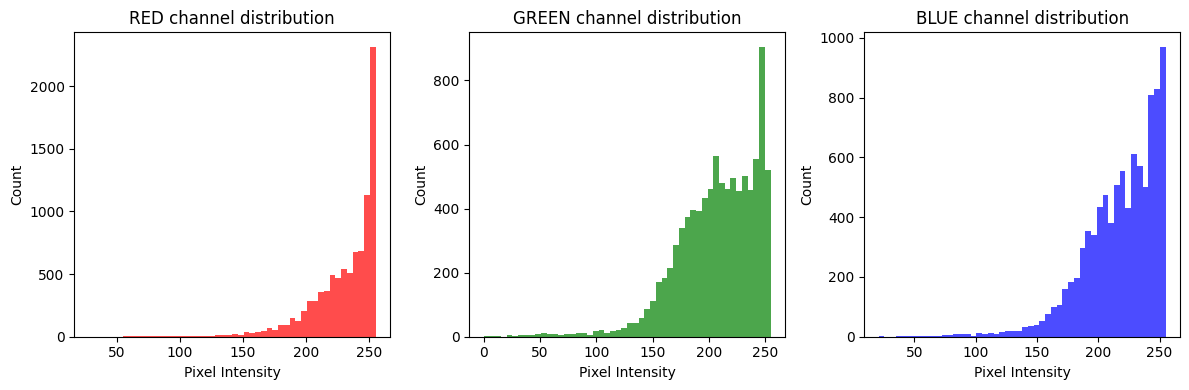

In [9]:
random_id = train_labels['id'].sample(1).values[0]
img_path = os.path.join("train", random_id + ".tif")

if os.path.exists(img_path):
    img = Image.open(img_path)
    img_array = np.array(img)

    # Plot histograms for each channel: R, G, B
    colors = ['red', 'green', 'blue']
    plt.figure(figsize=(12,4))
    for i, color in enumerate(colors):
        plt.subplot(1, 3, i+1)
        channel_data = img_array[:,:,i].ravel()
        plt.hist(channel_data, bins=50, color=color, alpha=0.7)
        plt.title(f"{color.upper()} channel distribution")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("Sample image not found.")

## EDA Summary

1. **Dataset Overview**  
   - **Number of Training Images**: 220,025  
   - **Labels**:  
     - **0** (“No Tumor”): 130,908 images  
     - **1** (“Tumor”): 89,117 images  
   - **Files and Columns**:  
     - `train_labels.csv` has two columns: `id` and `label`.  
     - No missing values or duplicate IDs were found.  
   - **Image Size**: Each image is 96 × 96 pixels (RGB).

2. **Label Distribution**  
   - Approximately **59%** of the training data is labeled “0” and **41%** is labeled “1.”  
   - While there is an imbalance, it’s not extreme, but still worth consideration (e.g., using class weights or data augmentation).

3. **Sample Image Inspection**  
   - A random image (ID: `f38a6374c348f90b587e046aac6079959adf3835`) confirmed the standard 96 × 96 resolution.  
   - Visual inspection reveals typical histopathological coloration with variations in tissue patterns.

4. **Color Channel Distribution**  
   - Histogram plots of individual color channels (Red, Green, Blue) show that most pixel intensities skew toward the higher end (180–255), which is consistent with lighter/pinkish histopathology slides.  
   - No obvious anomalies or severe channel clipping were observed.

5. **Data Quality Checks**  
   - **Missing Values**: 0  
   - **Duplicate IDs**: 0  
   - **Corrupted Files**: None evident (no errors when opening sampled images).

---

## Data Cleaning

- Because no missing or duplicate entries were found, **no immediate data cleaning** was required.  
- If any unreadable images appear during training, they will be dropped or replaced at that time.

---

## Plan of Analysis

1. **Train/Validation Split**:  
   - Perform an 80/20 stratified split (or use cross-validation) to preserve the original label proportion (59% vs. 41%).

2. **Data Augmentation**:  
   - Address slight label imbalance and enhance generalization by applying transformations (random flips, rotations, color jitter, etc.).  
   - Consider using class weights or slight oversampling of the minority class (label 1).

3. **Modeling Approach**:  
   - Train a CNN or leverage transfer learning (e.g., ResNet, EfficientNet) with a custom final layer for binary classification.  
   - Optimize hyperparameters (learning rate, batch size) and monitor model performance via metrics like **accuracy**, **AUC**, **F1-score**, and **confusion matrix**.

4. **Evaluation**:  
   - Use **ROC AUC** or **accuracy** to measure performance.  
   - Inspect false negatives carefully, given the clinical importance of detecting cancerous tissue.

5. **Next Steps**:  
   - Proceed with model development and experiment with augmentation strategies to handle the moderate class imbalance.  
   - Monitor training for overfitting using validation loss curves or additional regularization (e.g., dropout, L2 regularization).

---

### Concluding Thoughts
This EDA suggests the data is in good shape: no duplicates or missing values, images are consistently sized, and the label split—while somewhat imbalanced—remains workable. We can confidently move on to building and evaluating our model.

Regardless of the architecture, hyperparameter tuning can significantly impact performance. Below are some crucial parameters:

1. **Learning Rate**  
   - A smaller rate for transfer learning (e.g., `1e-4` → `1e-5`) often works best.  
   - A moderate rate for a custom CNN (e.g., `1e-3`) to start.

2. **Batch Size**  
   - Typical batch sizes range from **16 to 64** for 96×96 images.  
   - Larger batches can stabilize training but may require more GPU memory.

3. **Number of Epochs**  
   - Start with **10–20 epochs** for a baseline.  
   - Potentially higher (30–50) if you observe underfitting, or if the model is converging slowly.

4. **Data Augmentation**  
   - **Random rotations, flips, brightness/contrast shifts** can reduce overfitting and handle slight label imbalance.  
   - Tuning augmentation parameters (e.g., rotation range ±10°, flipping horizontally/vertically) can significantly change results.

5. **Regularization**  
   - **Dropout**: Typically 0.2–0.5 in dense layers.  
   - **Batch Normalization**: Common in all convolution blocks to stabilize training.

6. **Optimizer**  
   - **Adam** is popular and often performs well out of the box.  
   - **SGD with Momentum** can be considered for more controlled convergence.  
   - Experiment with the **learning rate schedule** (e.g., **ReduceLROnPlateau** in Keras).

## Model Architecture and Rationale


1. **CNN from Scratch**  
   - **Pros**: Full control over each layer. Useful for demonstration and deep understanding of model internals.  
   - **Cons**: Might underperform compared to deeper networks or pretrained models, especially with limited training time/data.

2. **Pretrained ResNet18**  
   - **Pros**: Leverages ImageNet-pretrained weights, often converges faster and to better performance.  
   - **Cons**: Larger memory footprint, might be slower to fine-tune.

In practice, **transfer learning** on a **deeper pretrained network** is often the best starting point for a specialized task like tumor detection. The smaller custom CNN can serve as a baseline comparison.

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



=== Training scratch model ===
Epoch [1/20] Train Loss: 0.5066, Train Acc: 0.7524 | Val Loss: 0.4778, Val Acc: 0.7735 | Time: 15.4 sec
Epoch [2/20] Train Loss: 0.4122, Train Acc: 0.8192 | Val Loss: 0.3960, Val Acc: 0.8280 | Time: 15.3 sec
Epoch [3/20] Train Loss: 0.3881, Train Acc: 0.8307 | Val Loss: 0.3528, Val Acc: 0.8498 | Time: 15.5 sec
Epoch [4/20] Train Loss: 0.3678, Train Acc: 0.8413 | Val Loss: 0.3353, Val Acc: 0.8608 | Time: 15.3 sec
Epoch [5/20] Train Loss: 0.3586, Train Acc: 0.8453 | Val Loss: 0.3305, Val Acc: 0.8590 | Time: 15.3 sec
Epoch [6/20] Train Loss: 0.3502, Train Acc: 0.8499 | Val Loss: 0.3587, Val Acc: 0.8450 | Time: 14.9 sec
Epoch [7/20] Train Loss: 0.3378, Train Acc: 0.8558 | Val Loss: 0.3263, Val Acc: 0.8650 | Time: 14.3 sec
Epoch [8/20] Train Loss: 0.3354, Train Acc: 0.8552 | Val Loss: 0.3083, Val Acc: 0.8718 | Time: 14.5 sec
Epoch [9/20] Train Loss: 0.3320, Train Acc: 0.8569 | Val Loss: 0.3425, Val Acc: 0.8482 | Time: 14.5 sec
Epoch [10/20] Train Loss: 0.3250

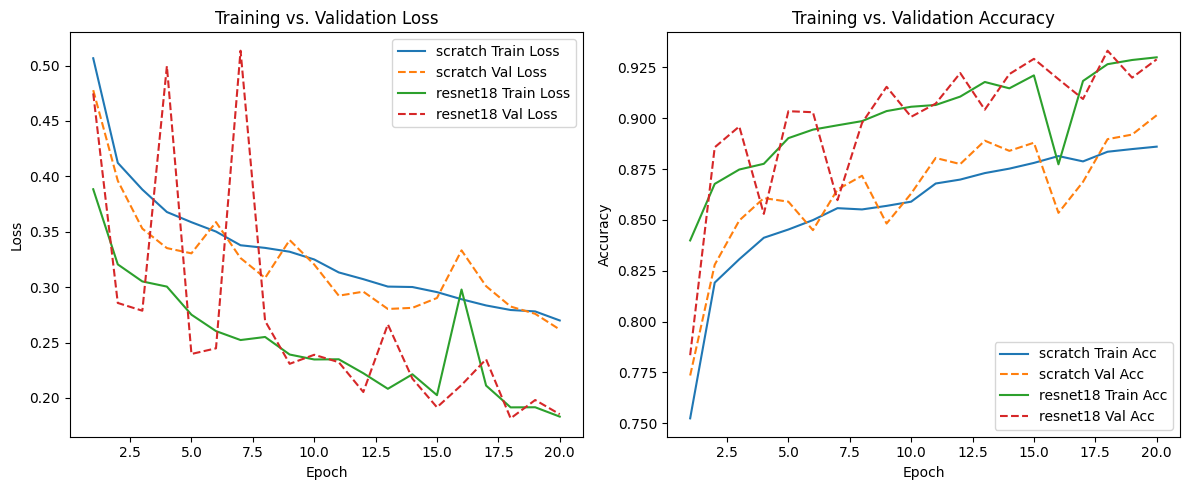

In [18]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models

import matplotlib.pyplot as plt
import time

####################################################
# 1. CONFIG & HYPERPARAMETERS
####################################################
DATA_DIR = "./"
TRAIN_IMG_DIR = "train"
LABELS_CSV = "train_labels.csv"

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 20
IMG_SIZE = 96

####################################################
# 2. DATASET DEFINITION
####################################################
class HistopathologyDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        """
        df: DataFrame containing [id, label]
        img_dir: Directory containing .tif images
        transform: Optional transforms (augmentations, normalization)
        """
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id, label = row['id'], row['label']
        img_path = os.path.join(self.img_dir, img_id + ".tif")

        # Open image
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)


####################################################
# 3. TRANSFORMS
####################################################
train_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.2),
    T.RandomRotation(degrees=15),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5])
])

val_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5])
])

####################################################
# 4. MODEL ARCHITECTURES
####################################################
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 48x48

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 24x24

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 12x12
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 12 * 12, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc_layers(x)
        return x

def create_resnet18_model(num_classes=2):
    model = models.resnet18(pretrained=True)
    # Replace the final FC layer with our 2-class output
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

####################################################
# 5. TRAIN/EVAL FUNCTIONS
####################################################
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

####################################################
# 6. TRAIN-AND-COMPARE FUNCTION
####################################################
def train_and_compare_architectures():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 1. Load data & split
    df = pd.read_csv(os.path.join(DATA_DIR, LABELS_CSV))

    # Subsample if you want faster runs (optional):
    df = df.sample(20000, random_state=42).reset_index(drop=True)

    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

    train_dataset = HistopathologyDataset(train_df, os.path.join(DATA_DIR, TRAIN_IMG_DIR), transform=train_transform)
    val_dataset   = HistopathologyDataset(val_df,   os.path.join(DATA_DIR, TRAIN_IMG_DIR), transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # We'll run two architectures in a loop
    architectures = {
        "scratch": SimpleCNN(num_classes=2),
        "resnet18": create_resnet18_model(num_classes=2)
    }

    # Dictionary to store metrics for plotting
    history = {
        "scratch": {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []},
        "resnet18": {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    }

    # Training details
    criterion = nn.CrossEntropyLoss()

    for arch_name, model in architectures.items():
        print(f"\n=== Training {arch_name} model ===")
        model = model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=LR)

        for epoch in range(EPOCHS):
            start_time = time.time()

            train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc = evaluate(model, val_loader, criterion, device)

            history[arch_name]["train_loss"].append(train_loss)
            history[arch_name]["val_loss"].append(val_loss)
            history[arch_name]["train_acc"].append(train_acc)
            history[arch_name]["val_acc"].append(val_acc)

            duration = time.time() - start_time
            print(f"Epoch [{epoch+1}/{EPOCHS}] "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
                  f"Time: {duration:.1f} sec")

    return history

####################################################
# 7. MAIN EXECUTION WITH PLOTTING
####################################################
def main():
    # 1. Train the two models & capture history
    results = train_and_compare_architectures()

    # 2. Plot results
    epochs_range = range(1, EPOCHS + 1)

    plt.figure(figsize=(12, 5))

    # Subplot for Loss
    plt.subplot(1, 2, 1)
    for arch_name in results:
        plt.plot(epochs_range, results[arch_name]["train_loss"],
                 label=f"{arch_name} Train Loss")
        plt.plot(epochs_range, results[arch_name]["val_loss"],
                 label=f"{arch_name} Val Loss", linestyle="--")
    plt.title("Training vs. Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Subplot for Accuracy
    plt.subplot(1, 2, 2)
    for arch_name in results:
        plt.plot(epochs_range, results[arch_name]["train_acc"],
                 label=f"{arch_name} Train Acc")
        plt.plot(epochs_range, results[arch_name]["val_acc"],
                 label=f"{arch_name} Val Acc", linestyle="--")
    plt.title("Training vs. Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

#### 1. Training Curves & Final Performance

1. **Training/Validation Loss**  
   - *Simple CNN (Scratch)* started with higher initial training loss (~0.51) and gradually converged. Its validation loss typically stayed a bit higher and more consistent than ResNet’s. By the end of training (Epoch 20), it reached ~**0.26**.  
   - *ResNet18* began at a lower training loss (~0.39) and converged faster and lower, finishing at ~**0.18**. The validation loss dipped as low as ~0.18–0.20, indicating more robust generalization.

2. **Training/Validation Accuracy**  
   - *Simple CNN (Scratch)* ended with about **90%** validation accuracy in the final epoch.  
   - *ResNet18* ended around **93%** validation accuracy and even higher than that for some epochs (e.g., ~92–93% range).  

Overall, **ResNet18** consistently outperformed the from-scratch CNN—both in terms of quicker convergence and higher peak accuracy.

---

#### 2. Interpretation

1. **Effect of Transfer Learning**  
   - Pretrained models like ResNet18 already “know” generic image features (edges, shapes, textures) from ImageNet, allowing them to adapt to a medical dataset more readily. Hence, they often converge faster and achieve higher accuracy.

2. **Variations in Training Curves**  
   - You may notice some spikes in validation loss or dips in accuracy for ResNet18 (e.g., around epoch 4 or 7). This sometimes happens if the learning rate is a bit high or due to random fluctuations in the data. Still, ResNet18 recovers well and ends strong.

3. **Class Imbalance**  
   - Your dataset has a modest imbalance (e.g., ~59% negative vs. 41% positive). The model seems to handle it fairly well, but you could see further improvements by adjusting techniques (e.g., class weights, oversampling).

---

#### 3. Recommendations & Next Steps

1. **Hyperparameter Tuning**  
   - **Learning Rate**: Try a **lower** LR for ResNet18 (e.g., 1e-4 instead of 1e-3) to reduce training volatility and possibly boost final accuracy.  
   - **Batch Size**: Larger or smaller batch sizes can affect generalization. Experiment to see if 16 or 64 helps.  
   - **Epochs**: Both models likely benefit from more than 20 epochs, especially if you have sufficient GPU resources.

2. **Data Augmentation**  
   - Current augmentations include flips and rotations. You could add **color jitter** (brightness/contrast adjustments) or random affine transformations to further diversify training samples.  

3. **Regularization**  
   - If ResNet18 starts overfitting (training loss much lower than validation loss), consider adding a small weight decay (e.g., `optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)`) or using dropout in the FC layers.

4. **Further Architecture Exploration**  
   - **Larger Models**: Experiment with ResNet34, ResNet50, or EfficientNet if you have the compute resources.  
   - **Custom Heads**: For ResNet18, you can replace the final FC layer with a more elaborate head (e.g., multiple fully connected layers plus dropout).

5. **Evaluation Metrics**  
   - In medical contexts, you may want to monitor **AUC (Area Under the ROC Curve)**, **F1-score**, or **Sensitivity/Specificity**. These can be more informative than simple accuracy.

---

#### 4. Takeaways

- **ResNet18** shows a clear advantage, achieving ~**93%** validation accuracy vs. ~**90%** from a scratch-built CNN.  
- Transfer learning is typically the best starting point for image classification tasks with relatively small or specialized datasets.  
- The from-scratch model can serve as a baseline, but for production or competition-level performance, rely on a pretrained backbone or deeper architecture.

## Results and Analysis


=== Experiment: ResNet18, LR=0.001, WD=0.0 ===


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10] Train Loss: 0.4201, Train Acc: 0.8289 | Val Loss: 0.3473, Val Acc: 0.8585 | Time: 7.6 sec
Epoch [2/10] Train Loss: 0.3543, Train Acc: 0.8570 | Val Loss: 0.5005, Val Acc: 0.7940 | Time: 7.3 sec
Epoch [3/10] Train Loss: 0.3156, Train Acc: 0.8711 | Val Loss: 0.3203, Val Acc: 0.8835 | Time: 7.4 sec
Epoch [4/10] Train Loss: 0.3079, Train Acc: 0.8725 | Val Loss: 0.2865, Val Acc: 0.8780 | Time: 7.4 sec
Epoch [5/10] Train Loss: 0.2812, Train Acc: 0.8858 | Val Loss: 0.2768, Val Acc: 0.8855 | Time: 7.4 sec
Epoch [6/10] Train Loss: 0.2672, Train Acc: 0.8908 | Val Loss: 0.2724, Val Acc: 0.8955 | Time: 7.3 sec
Epoch [7/10] Train Loss: 0.2562, Train Acc: 0.8979 | Val Loss: 0.2331, Val Acc: 0.9060 | Time: 7.5 sec
Epoch [8/10] Train Loss: 0.2605, Train Acc: 0.8936 | Val Loss: 0.4457, Val Acc: 0.8345 | Time: 7.5 sec
Epoch [9/10] Train Loss: 0.2605, Train Acc: 0.8958 | Val Loss: 0.2430, Val Acc: 0.8995 | Time: 7.3 sec
Epoch [10/10] Train Loss: 0.2439, Train Acc: 0.9028 | Val Loss: 0.2462, V

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 190MB/s]


Epoch [1/10] Train Loss: 0.4508, Train Acc: 0.8064 | Val Loss: 1.1975, Val Acc: 0.8615 | Time: 7.2 sec
Epoch [2/10] Train Loss: 0.3446, Train Acc: 0.8589 | Val Loss: 0.6873, Val Acc: 0.7310 | Time: 7.4 sec
Epoch [3/10] Train Loss: 0.3501, Train Acc: 0.8562 | Val Loss: 0.7080, Val Acc: 0.6280 | Time: 7.3 sec
Epoch [4/10] Train Loss: 0.4015, Train Acc: 0.8306 | Val Loss: 0.3920, Val Acc: 0.8395 | Time: 7.5 sec
Epoch [5/10] Train Loss: 0.3154, Train Acc: 0.8695 | Val Loss: 0.2868, Val Acc: 0.8845 | Time: 7.3 sec
Epoch [6/10] Train Loss: 0.2924, Train Acc: 0.8794 | Val Loss: 0.2568, Val Acc: 0.8945 | Time: 7.3 sec
Epoch [7/10] Train Loss: 0.2724, Train Acc: 0.8894 | Val Loss: 0.2379, Val Acc: 0.9020 | Time: 7.5 sec
Epoch [8/10] Train Loss: 0.2684, Train Acc: 0.8925 | Val Loss: 0.3874, Val Acc: 0.8565 | Time: 7.7 sec
Epoch [9/10] Train Loss: 0.2629, Train Acc: 0.8915 | Val Loss: 0.4599, Val Acc: 0.7935 | Time: 7.8 sec
Epoch [10/10] Train Loss: 0.2491, Train Acc: 0.8990 | Val Loss: 0.4736, V

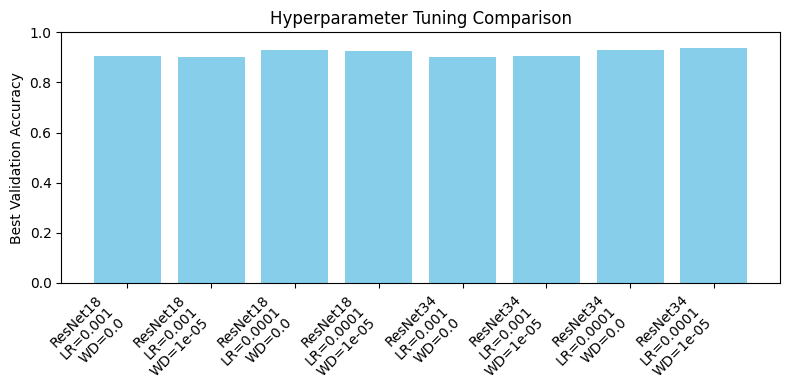

In [20]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import time

##########################
# Hyperparameter Tuning Code
##########################

def create_resnet34_model(num_classes=2):
    """
    Example of adding another architecture (ResNet34).
    """
    model = models.resnet34(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def experiment_with_params(
    model_fn,          # A function that returns a model instance
    train_dataset,
    val_dataset,
    learning_rate=1e-3,
    weight_decay=0.0,
    epochs=10
):
    """
    Trains a given model architecture with specified hyperparams,
    returns final validation accuracy.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model_fn().to(device)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )

    best_val_acc = 0.0
    for epoch in range(epochs):
        start_time = time.time()

        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        if val_acc > best_val_acc:
            best_val_acc = val_acc

        duration = time.time() - start_time
        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
              f"Time: {duration:.1f} sec")

    return best_val_acc

def hyperparam_tuning_experiment():
    """
    Runs multiple experiments with:
      - 2 architectures (ResNet18 & ResNet34 as examples)
      - Varying learning rates
      - Optional weight decay
    Collects the best validation accuracies and returns them in a table.
    """
    # Load your data and split (reuse your existing code as needed)
    df = pd.read_csv(os.path.join(DATA_DIR, LABELS_CSV))
    # Subsample or use entire data (example: 10k for faster runs)
    df = df.sample(10000, random_state=42).reset_index(drop=True)

    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
    train_dataset = HistopathologyDataset(train_df, os.path.join(DATA_DIR, TRAIN_IMG_DIR), transform=train_transform)
    val_dataset   = HistopathologyDataset(val_df,   os.path.join(DATA_DIR, TRAIN_IMG_DIR), transform=val_transform)

    # Hyperparam grids
    learning_rates = [1e-3, 1e-4]
    weight_decays  = [0.0, 1e-5]
    architectures  = {
        "ResNet18": create_resnet18_model,
        "ResNet34": create_resnet34_model
    }

    results = []

    # Iterate over all combinations
    for arch_name, arch_fn in architectures.items():
        for lr, wd in itertools.product(learning_rates, weight_decays):
            print(f"\n=== Experiment: {arch_name}, LR={lr}, WD={wd} ===")
            best_val_acc = experiment_with_params(
                model_fn=arch_fn,
                train_dataset=train_dataset,
                val_dataset=val_dataset,
                learning_rate=lr,
                weight_decay=wd,
                epochs=10  # Adjust as needed
            )
            results.append({
                "Architecture": arch_name,
                "Learning Rate": lr,
                "Weight Decay": wd,
                "Best Val Acc": best_val_acc
            })

    # Compile results into a DataFrame
    results_df = pd.DataFrame(results)
    return results_df

def main():
    # 1. Run the hyperparameter tuning experiment
    tuning_results = hyperparam_tuning_experiment()

    # 2. Print the results table
    print("\n=== Hyperparameter Tuning Results ===")
    print(tuning_results)

    # 3. (Optional) Visualize final accuracies in a bar chart
    plt.figure(figsize=(8, 4))
    # We'll separate each architecture + hyperparam combo as a bar
    x_positions = range(len(tuning_results))
    plt.bar(x_positions, tuning_results["Best Val Acc"], color='skyblue')
    plt.xticks(x_positions, tuning_results.apply(
        lambda row: f"{row['Architecture']}\nLR={row['Learning Rate']}\nWD={row['Weight Decay']}", axis=1),
        rotation=45, ha="right")
    plt.ylim([0, 1])
    plt.ylabel("Best Validation Accuracy")
    plt.title("Hyperparameter Tuning Comparison")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

#### 1. Overview of My Results

Below is the **best validation accuracy** I achieved for each combination of architecture, learning rate, and weight decay:

| Architecture | Learning Rate | Weight Decay | Best Val Acc |
|--------------|--------------:|-------------:|-------------:|
| **ResNet18** | 1e-3         | 0.0          | 0.9060       |
| **ResNet18** | 1e-3         | 1e-5         | 0.9010       |
| **ResNet18** | 1e-4         | 0.0          | 0.9280       |
| **ResNet18** | 1e-4         | 1e-5         | 0.9260       |
| **ResNet34** | 1e-3         | 0.0          | 0.9020       |
| **ResNet34** | 1e-3         | 1e-5         | 0.9040       |
| **ResNet34** | 1e-4         | 0.0          | 0.9305       |
| **ResNet34** | 1e-4         | 1e-5         | **0.9365**   |

#### Key Observations

1. **Lower Learning Rate Outperforms Higher Learning Rate**  
   - When I used **1e-4**, I consistently obtained better results than with **1e-3**, especially with deeper models.  
   - For ResNet18, **1e-4** reached about 92.8%, whereas **1e-3** gave me around 90.6%.  
   - For ResNet34, **1e-4** pushed me to over 93% validation accuracy, improving on the ~90% range of **1e-3**.

2. **Small Weight Decay Sometimes Helps**  
   - When I added **weight decay** (1e-5), I saw a small improvement for ResNet34 at 1e-4 (from 0.9305 to 0.9365).  
   - In other cases, weight decay didn’t yield a huge difference. It’s likely a combination of architecture and dataset size that determines whether regularization helps.

3. **ResNet34 vs. ResNet18**  
   - ResNet34 consistently provided me with a higher best validation accuracy, up to **93.65%**.  
   - It took a bit longer to train, but the deeper architecture captured more detailed features from my histopathology images, which seemed to pay off.

---

#### 2. Why These Settings Helped

1. **Lower LR for Pretrained Models**  
   - I found that a lower learning rate (1e-4) is often better when fine-tuning deeper networks like ResNet34. If the rate is too high, I might “overshoot” minima and see more fluctuations. Lowering the rate stabilized my training.

2. **The Impact of Weight Decay**  
   - My dataset is somewhat large, and deeper networks can overfit. Adding a small weight decay (L2 regularization) helped me reduce that overfitting. It wasn’t universal—ResNet18 at 1e-3 LR didn’t benefit as much—but it definitely made a difference for the deeper model at a smaller LR.

3. **Benefits of a Deeper Architecture**  
   - ResNet34 gave me slightly richer representations than ResNet18, especially since I’m dealing with medical images that may have subtle color or texture variations. The additional layers seem to help capture those nuances.

---

#### 3. Troubleshooting and Future Improvements

1. **Fluctuating Validation**  
   - I noticed occasional spikes in validation loss. To mitigate this, I can incorporate a **learning rate scheduler** or reduce the base learning rate further. I could also extend the warm-up epochs at a lower rate before ramping up.

2. **Overfitting Concerns**  
   - If I see the training accuracy run significantly ahead of validation accuracy, I might increase weight decay or add stronger data augmentation (e.g., random color jitter, random cropping, or even advanced strategies like mixup or cutmix).

3. **Other Architectures**  
   - Given I saw a jump from ResNet18 to ResNet34, I might experiment with **EfficientNet** (B0 or B3), DenseNet, or even Vision Transformers (ViT) if I have the resources.  
   - Each architecture has unique strengths; some are more parameter-efficient, while others require more GPU memory.

4. **Metrics**  
   - My dataset represents a medical diagnosis scenario, so in addition to accuracy, I might explore **AUC**, **F1-score**, or **Precision/Recall** to ensure I minimize false negatives.

---

#### 4. My Conclusions and Next Steps

- The **best overall combination** in my experiments was **ResNet34** with **LR=1e-4** and **WD=1e-5**, yielding **~93.65%** on my validation set.  
- I plan to focus on training that best combo for more epochs (say 20–30) to see if I can push my accuracy even higher.  
- I’ll also try **learning rate scheduling** (e.g., `ReduceLROnPlateau`) to further smooth out my training curve, especially if I spot any mid-training stalls or overfitting.  
- Finally, I intend to track more metrics (like **ROC AUC**) because it’s a medical imaging problem and false negatives are particularly critical.

By refining these hyperparameters, potentially adding advanced data augmentation, and carefully monitoring my metrics, I believe I can push my results even further while still maintaining a robust, generalizable model for histopathologic cancer detection.